In [ ]:
!pip install open-cv

ERROR: Could not find a version that satisfies the requirement open-cv (from versions: none)
ERROR: No matching distribution found for open-cv


In [ ]:
!mkdir "/content/Datasets/"
#!mkdir "/content/Datasets/Sheeps/"
#!mkdir "/content/Datasets/Oranges/"
!mkdir "/content/Datasets/BlueBerries/"

#!unzip "/content/Aerial Sheep.v1-v1.tensorflow.zip" -d "/content/Datasets/Sheeps/"
#!unzip "/content/Agritech-OrangeDetection.v3i.tensorflow.zip" -d "/content/Datasets/Oranges/"
!unzip "/content/BlueBerries.v959i.tensorflow.zip" -d "/content/Datasets/BlueBerries/"

Archive:  /content/BlueBerries.v959i.tensorflow.zip
 extracting: /content/Datasets/BlueBerries/README.dataset.txt  
 extracting: /content/Datasets/BlueBerries/README.roboflow.txt  
   creating: /content/Datasets/BlueBerries/test/
 extracting: /content/Datasets/BlueBerries/test/08492A_jpg.rf.89deaecbca544d173c37fa18bd65befe.jpg  
 extracting: /content/Datasets/BlueBerries/test/11366_grande_jpg.rf.4c37124156cccd8f5a2afa8bdf086eeb.jpg  
 extracting: /content/Datasets/BlueBerries/test/Centurion_jpg.rf.b04b3c149ebd08e46a04432c66db0d04.jpg  
 extracting: /content/Datasets/BlueBerries/test/J318-05-1-_jpg.rf.4b8aee7e6fb39ae22460d43e924a823b.jpg  
 extracting: /content/Datasets/BlueBerries/test/TOro_Blueberry_2_720x_jpg.rf.df6c342e65f6cbceba6325ee4ea21d18.jpg  
 extracting: /content/Datasets/BlueBerries/test/_annotations.csv  
 extracting: /content/Datasets/BlueBerries/test/blueberry_cluster_jpg.rf.20917cf790c912d80765a337069c4920.jpg  
 extracting: /content/Datasets/BlueBerries/test/images-3-_

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-pe0iiz2v
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-pe0iiz2v
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36589 sha256=147a932ec6e7478130f311b98b15fdec6883cde8fa1d2723afab081b3504504e
  Stored in directory: /tmp/pip-ephem-wheel-cache-gohbdu2q/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-07-22 13:36:01--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

In [ ]:
# image = cv2.imread('/content/Datasets/Oranges/train/00038_jpg.rf.a4a81b0a2b676811b9382e918781eb99.jpg')
image = cv2.imread('/content/Datasets/BlueBerries/valid/76380A-1-_jpg.rf.aa0712516b698cdf6aa847c9eebee5ab.jpg')
# image = cv2.imread('/content/Datasets/Sheeps/train/DJI_0004_0277_jpg.rf.06e57d57e6730c7b2a266f9cefb9266b.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

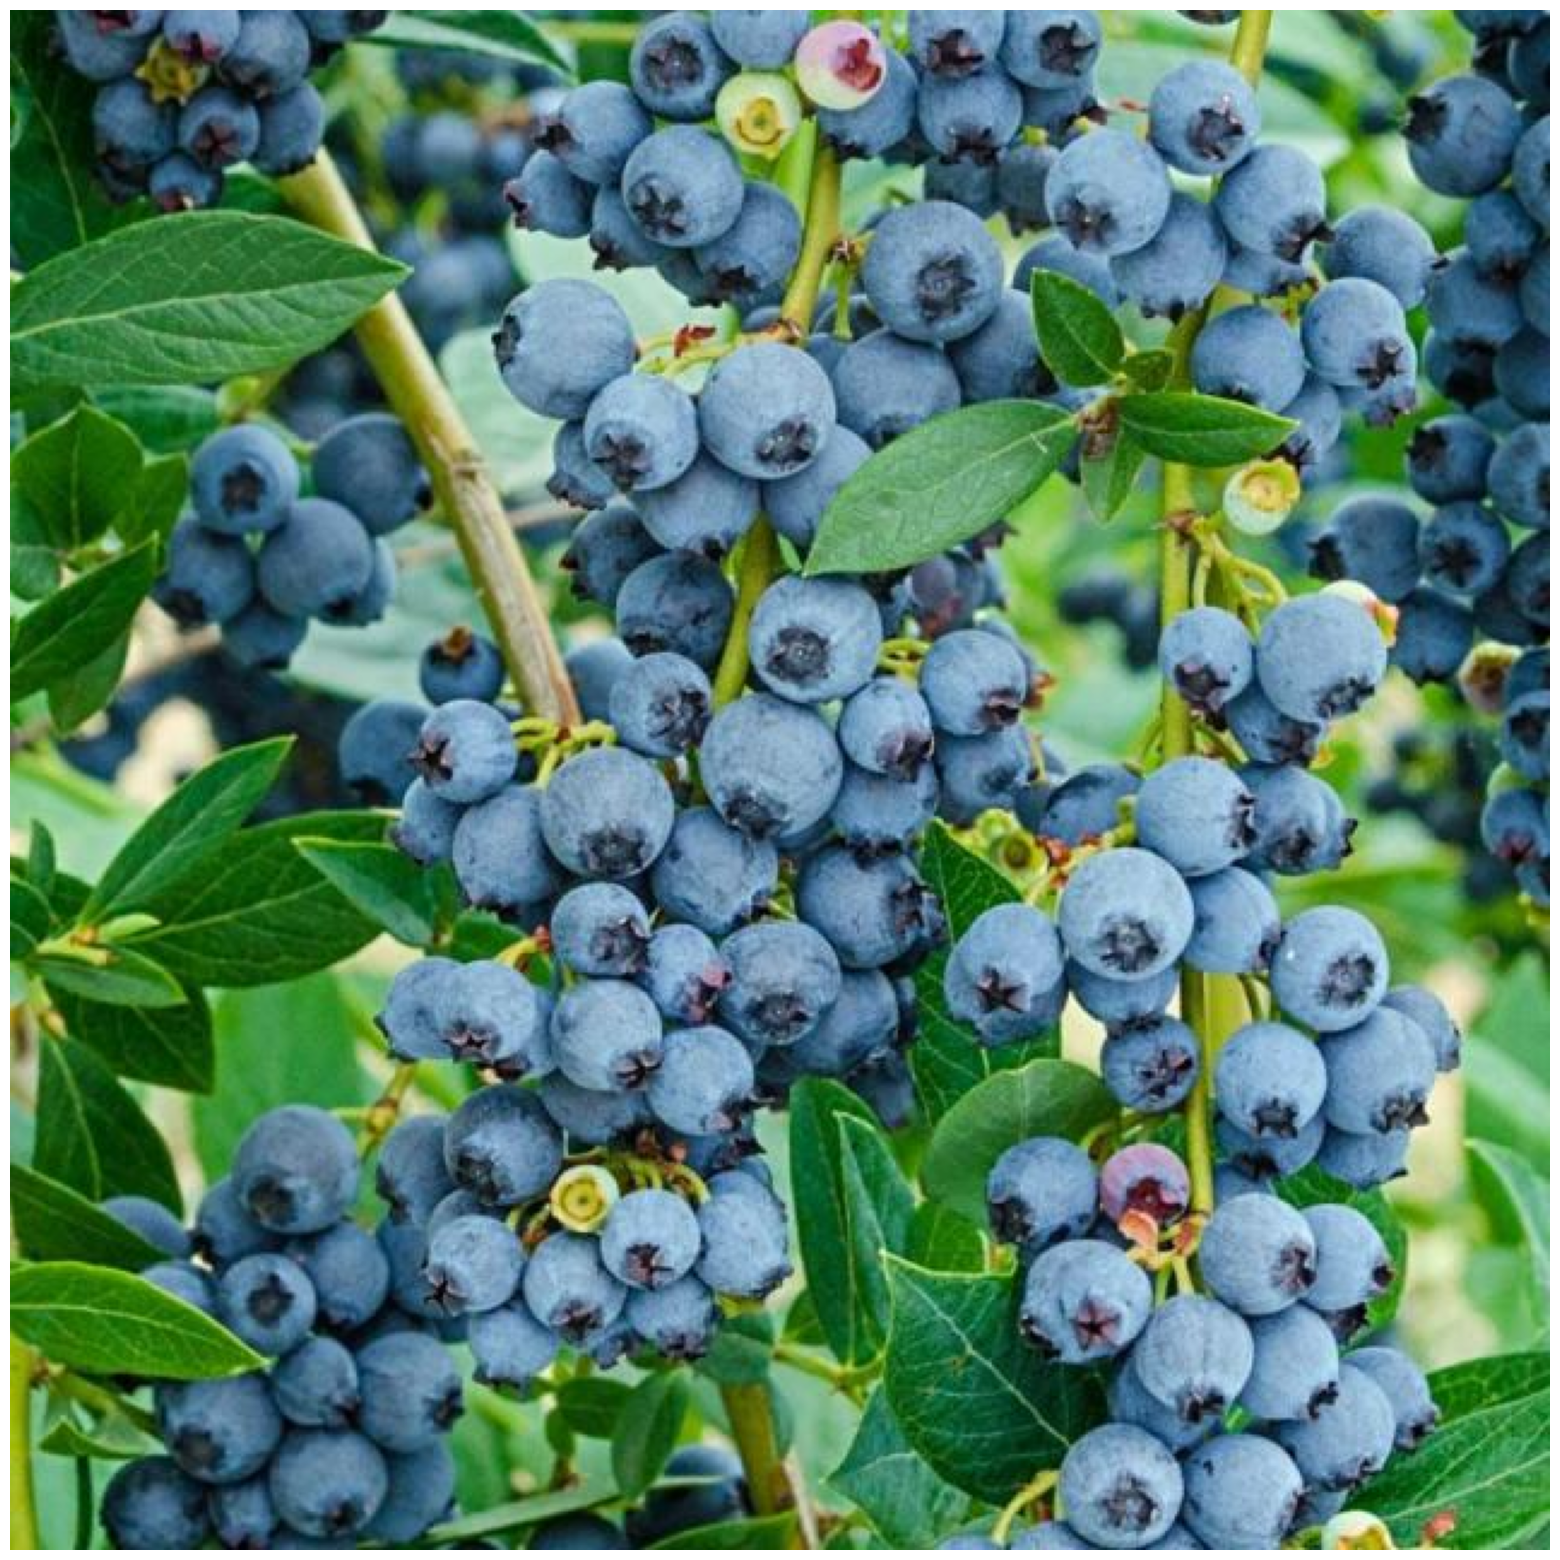

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
 !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

--2023-07-22 13:36:56--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.224.249.63, 13.224.249.96, 13.224.249.83, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.224.249.63|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   147MB/s    in 16s     

2023-07-22 13:37:12 (157 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



## Automatic Mask Generation

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
masks = mask_generator.generate(image)

In [ ]:
print(len(masks))
print(masks[0].keys())

376
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


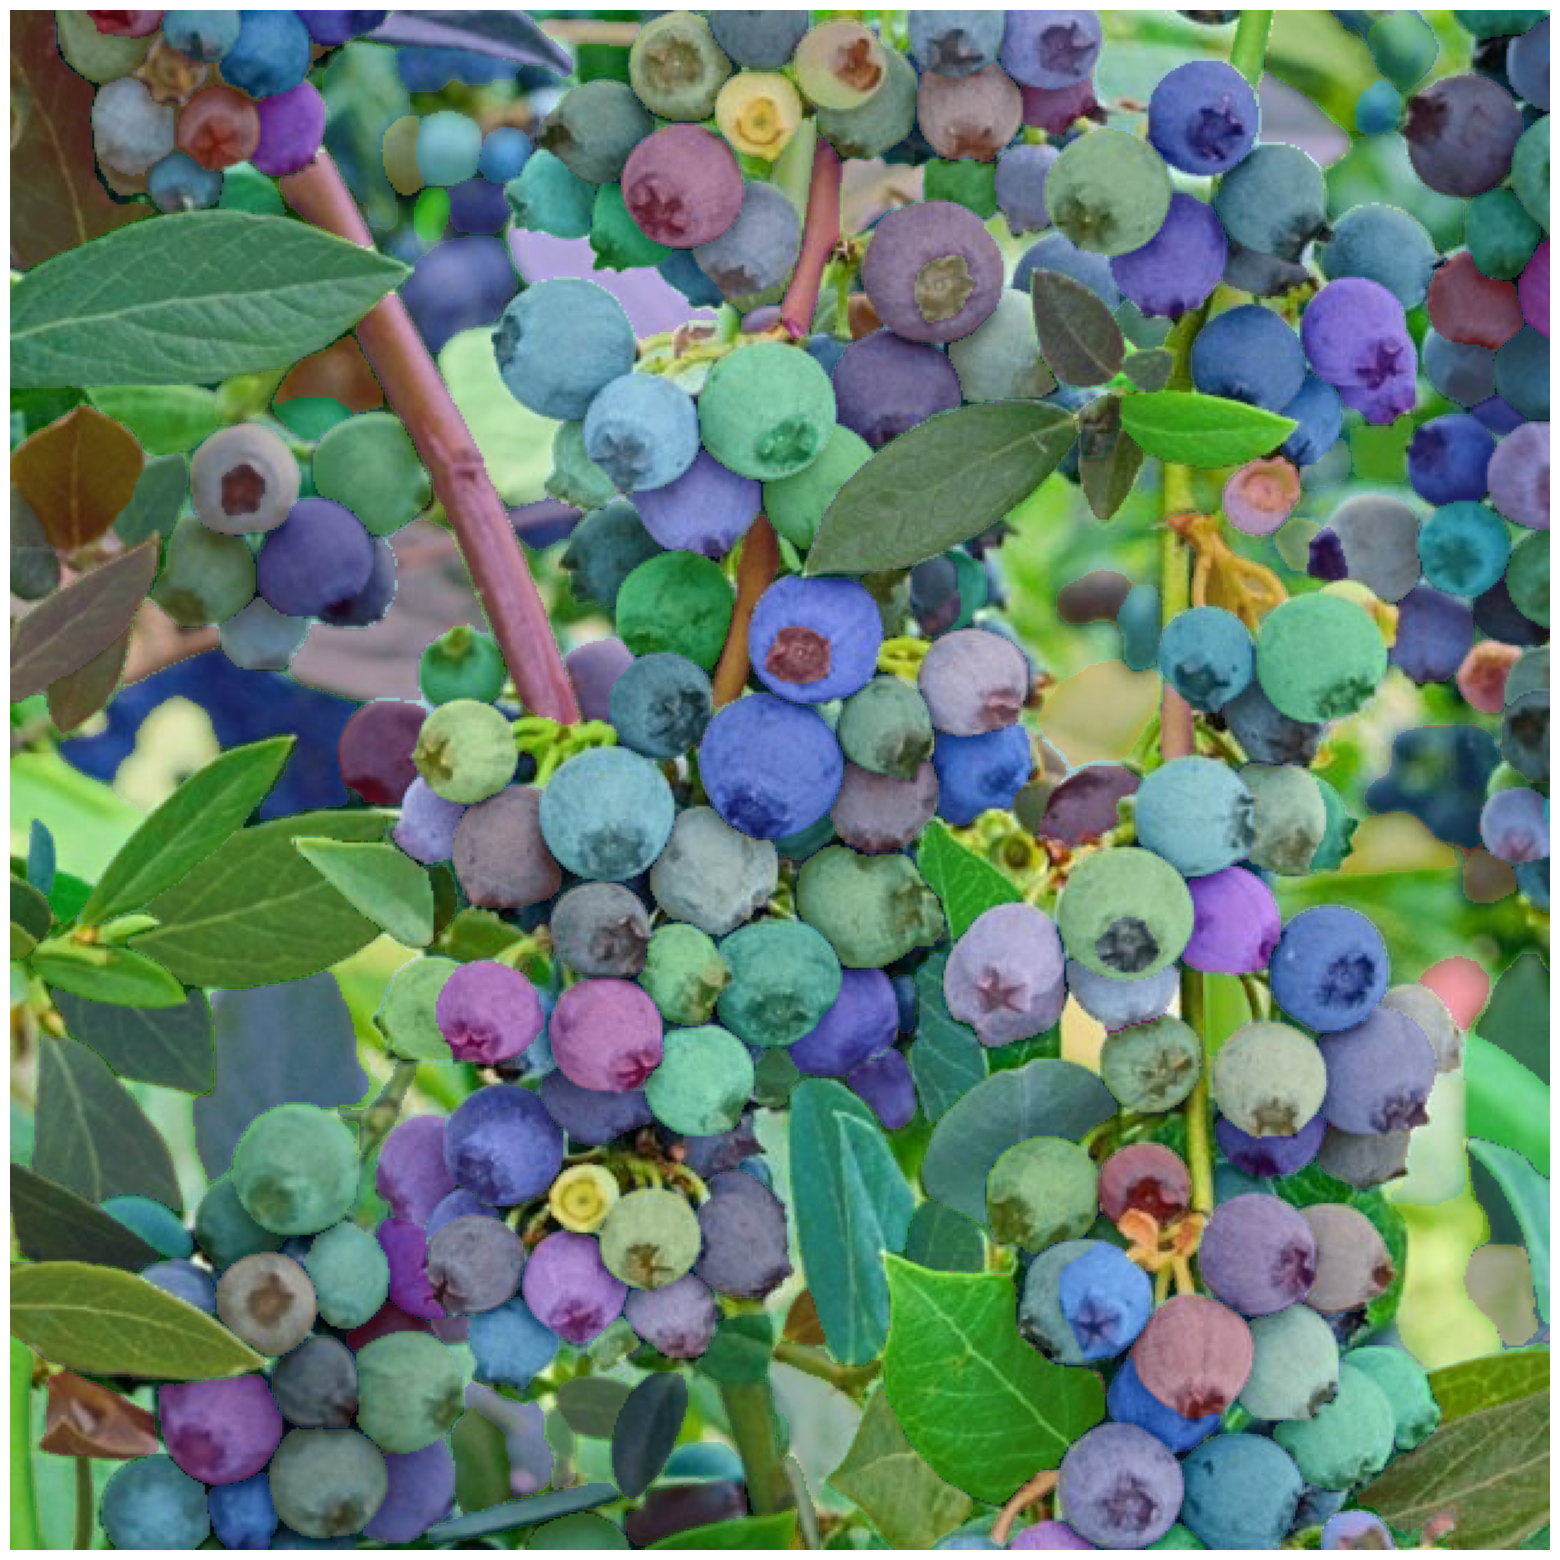

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Training the Classification Model

In this section, we train a classification model on the labeled masks from the dataset, and validate it.

In [ ]:
import pandas as pd
import os
#dataset_path = "/content/Datasets/Oranges/train"
dataset_path = "/content/Datasets/BlueBerries/train"

# Read the CSV file containing the annotations
annotations_df = pd.read_csv(f'{dataset_path}/_annotations.csv')

# Create  directories to save the cropped images
os.makedirs(f'{dataset_path}/cropped_images_positive', exist_ok=True)
os.makedirs(f'{dataset_path}/cropped_images_negative', exist_ok=True)

def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])

    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

    area_of_intersection = i_height * i_width

    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1

    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1

    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

    iou = area_of_intersection / area_of_union

    return iou
def resize_image(image):
    # Get the current dimensions of the image
    height, width = image.shape[:2]

    # Determine the maximum dimension
    max_dim = max(height, width)

    # Calculate the scale factor to resize the image
    scale = 224 / max_dim

    # Calculate the new dimensions
    new_width = int(width * scale)
    new_height = int(height * scale)

    # Resize the image while preserving the aspect ratio
    resized_image = cv2.resize(image, (new_width, new_height))

    return resized_image

def crop_image(xmin, ymin, xmax, ymax, image):
    # Calculate the original width and height of the bounding box
    box_width = xmax - xmin
    box_height = ymax - ymin

    # Calculate the center coordinates of the bounding box
    center_x = int((xmin + xmax) / 2)
    center_y = int((ymin + ymax) / 2)

    # Calculate the size of the largest dimension
    max_dim = max(box_width, box_height)

    # Calculate the new bounding box coordinates
    new_xmin = max(center_x - max_dim // 2, 0)
    new_ymin = max(center_y - max_dim // 2, 0)
    new_xmax = new_xmin + max_dim
    new_ymax = new_ymin + max_dim

    # Crop the new bounding box region from the image
    cropped_image = resize_image(image[new_ymin:new_ymax, new_xmin:new_xmax])
    new_image = np.zeros((224, 224, 3), dtype=np.uint8)

    # Calculate the position to place the object in the center
    x_offset = int((224 - cropped_image.shape[1]) / 2)
    y_offset = int((224 - cropped_image.shape[0]) / 2)

    # Paste the cropped image in the center of the new image
    new_image[y_offset:y_offset+cropped_image.shape[0], x_offset:x_offset+cropped_image.shape[1]] = cropped_image
    return new_image


groups = annotations_df.groupby("filename")
for image_name, group in groups:
  image = cv2.imread(dataset_path + "/" + image_name)
  masks = mask_generator.generate(image)
  for index, mask in enumerate(masks):
    masked_image = image * mask["segmentation"][:, :, np.newaxis]
    cropped_masked_image = crop_image(mask["bbox"][0], mask["bbox"][1],
                                      mask["bbox"][0]+ mask["bbox"][2] ,
                                      mask["bbox"][1] + mask["bbox"][3] , masked_image)

    ground_truth_boxes = group[["xmin", "ymin", "xmax", "ymax"]].to_numpy()
    iou = 0
    for box in ground_truth_boxes:
      box1 = box
      box2 = [mask['bbox'][0], mask['bbox'][1], mask['bbox'][0]+ mask['bbox'][2], mask['bbox'][1] + mask['bbox'][3]]
      iou = max(get_iou(box1, box2), iou)
    if iou > 0.65:
      save_path = f'{dataset_path}/cropped_images_positive/{image_name}_object_{index}.jpg'
      cv2.imwrite(save_path, cropped_masked_image)

    else:
      save_path = f'{dataset_path}/cropped_images_negative/{image_name}_object_{index}.jpg'
      cv2.imwrite(save_path, cropped_masked_image)

### Feature Extraction

In [ ]:
import cv2
import numpy as np
import os
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
import torch
from torchvision import models, transforms
from torchvision.models.feature_extraction import get_graph_node_names, create_feature_extractor


# Load the pre-trained ResNet-34 model without the final fully connected layer
model = models.vit_b_16(pretrained=True)
# vit_b_16 = torch.nn.Sequential(*list(vit_b_16.children())[:-1])
vit_b_16 = create_feature_extractor(model, return_nodes=['encoder'])
# vit_b_16.eval()  # Set the model to evaluation mode

# Preprocessing transformations
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def extract_features(image):
    # Preprocess the image
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image = preprocess(image)
    image = image.unsqueeze(0)  # Add batch dimension

    # Extract features using the pre-trained ResNet-34 model (encoder)
    with torch.no_grad():
        features = vit_b_16(image)
        # print((features.shape))

    # Flatten and convert features to a numpy array
    # features = features.squeeze().numpy()
    # features = image.flatten()
    return features['encoder'].flatten().numpy()

# Path to the directory containing positive samples (blueberries)
positive_samples_path = f"{dataset_path}/cropped_images_positive"
negative_samples_path = f"{dataset_path}/cropped_images_negative"
# Initialize lists to store features and labels
features = []
labels = []

from tqdm import tqdm
num_pos = 0
num_neg = 0
# Load positive samples and extract features
for filename in tqdm(os.listdir(positive_samples_path)):
    if filename.endswith(".jpg"):
        num_pos+=1
        image = cv2.imread(os.path.join(positive_samples_path, filename))
        # Perform feature extraction on the image (e.g., color histograms, texture features)
        feature = extract_features(image)
        features.append(feature)
        labels.append(1)  # Positive class label (blueberries)

for filename in os.listdir(negative_samples_path):
    if filename.endswith(".jpg"):
        image = cv2.imread(os.path.join(negative_samples_path, filename))
        # Perform feature extraction on the image (e.g., color histograms, texture features)
        feature = extract_features(image)
        features.append(feature)
        labels.append(0)  # Negative class label (blueberries)
        num_neg+=1
        if num_neg == num_pos:
          break


# Convert lists to NumPy arrays
features = np.array(features)
labels = np.array(labels)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 125MB/s]
100%|██████████| 2113/2113 [03:28<00:00, 10.12it/s]


### Fitting

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, shuffle = True)

clf = svm.SVC()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9089834515366431

# Intersection Over Union

In [ ]:
def get_iou(ground_truth, pred):
    # coordinates of the area of intersection.
    ix1 = np.maximum(ground_truth[0], pred[0])
    iy1 = np.maximum(ground_truth[1], pred[1])
    ix2 = np.minimum(ground_truth[2], pred[2])
    iy2 = np.minimum(ground_truth[3], pred[3])

    # Intersection height and width.
    i_height = np.maximum(iy2 - iy1 + 1, np.array(0.))
    i_width = np.maximum(ix2 - ix1 + 1, np.array(0.))

    area_of_intersection = i_height * i_width

    # Ground Truth dimensions.
    gt_height = ground_truth[3] - ground_truth[1] + 1
    gt_width = ground_truth[2] - ground_truth[0] + 1

    # Prediction dimensions.
    pd_height = pred[3] - pred[1] + 1
    pd_width = pred[2] - pred[0] + 1

    area_of_union = gt_height * gt_width + pd_height * pd_width - area_of_intersection

    iou = area_of_intersection / area_of_union

    return iou


In [ ]:
valid_dataset_path = "/content/Datasets/BlueBerries/valid"
valid_annotations_df = pd.read_csv(f'{valid_dataset_path}/_annotations.csv')

def compute_masks(image_name):
  im_path  = valid_dataset_path + "/" + image_name
  image = cv2.imread(valid_dataset_path + "/" + image_name)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  masks = mask_generator.generate(image)
  object_masks = list()
  cnt = 0
  for mask in masks:
    masked_image = image * mask["segmentation"][:, :, np.newaxis]
    cropped_masked_image = crop_image(mask["bbox"][0], mask["bbox"][1],
                                      mask["bbox"][0]+ mask["bbox"][2] ,
                                      mask["bbox"][1] + mask["bbox"][3] , masked_image)


    features = extract_features(cropped_masked_image)
    if clf.predict(np.expand_dims(features, axis = 0 ) )  == 1:
      object_masks.append(mask)
      cnt+=1
  return [object_masks,cnt]

groups = valid_annotations_df.groupby("filename")
for image_name, group in groups:
  print(image_name)
  boxes = compute_masks(image_name)
  ground_truth_boxes = group[["xmin", "ymin", "xmax", "ymax"]].to_numpy()
  print(ground_truth_boxes)
  break

## Combining SAM with our classifier

In this section, we combined the trained classifier with the masks that SAM has segmented and generated. In short, if the classifier tells that a specific mask is a Blueberry, then it's counted.

In [ ]:

valid_dataset_path = "/content/Datasets/BlueBerries/valid"
valid_annotations_df = pd.read_csv(f'{valid_dataset_path}/_annotations.csv')

#returns number of positive masks to count
def compute_masks(image_name):
  im_path  = valid_dataset_path + "/" + image_name
  image = cv2.imread(valid_dataset_path + "/" + image_name)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  masks = mask_generator.generate(image)
  object_masks = list()
  cnt = 0
  for mask in masks:
    masked_image = image * mask["segmentation"][:, :, np.newaxis]
    cropped_masked_image = crop_image(mask["bbox"][0], mask["bbox"][1],
                                      mask["bbox"][0]+ mask["bbox"][2] ,
                                      mask["bbox"][1] + mask["bbox"][3] , masked_image)


    features = extract_features(cropped_masked_image)
    if clf.predict(np.expand_dims(features, axis = 0 ) )  == 1:
      cnt+= 1
  return cnt

In [ ]:
compute_masks("201705_NEWS01_170519992_AR_-1_0_jpg.rf.f255bc9db0736db9a8cd4e2587cf4948.jpg")

4

In [ ]:
compute_masks("Blueberries_PUB0010288_jpg.rf.48abaa640bf13b7243117aeecc2afa21.jpg")

19

In [ ]:
compute_masks("XF127_450x-1-_jpg.rf.919ae0bd8de28a11472ea44e47e52406.jpg")